# HW 3 problem 1

In [2]:
import ipdb
import random
import time
import math
import scipy
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigs
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix, diags

In [4]:
def dataset(p) -> (np.ndarray,np.ndarray):
    n = 10000
    mu1 = np.array([3/np.sqrt(p)] * p)
    mu2 = np.array([-3/np.sqrt(p)] * p)
    sigma = np.eye(p)
    data1 = np.random.multivariate_normal(mu1, sigma, size=5000)
    data2 = np.random.multivariate_normal(mu2, sigma, size=5000)
    X = np.concatenate((data1, data2), axis=0)
    cls1 = np.zeros(n//2, dtype=np.int32)
    cls2 = np.ones(n//2, dtype=np.int32)
    y = np.concatenate([cls1, cls2]).reshape((-1, 1))
    return X, y

In [5]:
def calc_acc(y_hat, y):
    acc = np.count_nonzero(y_hat-y)/y.size
    return max(1.0 - acc, acc)

In [6]:
def spectralClustering(X, y, k=5, t=10, algo='brute', perf=False) -> float:
    assert(X.shape[0] == y.shape[0])
    m = X.shape[0]    
    t1 = time.perf_counter()
    nbrs = NearestNeighbors(n_neighbors=k, algorithm=algo).fit(X)
    distances, indices = nbrs.kneighbors(X)
    t2 = time.perf_counter()
    if perf:
        print(f'Nearest Neighbours: {t2-t1:.4f} secs')
    
    t1 = time.perf_counter()
    A = np.zeros((m, m))
    
    for i in range(m):
        i_j = np.where((indices==i).sum(axis=1) == 1)[0]
        j_i = indices[i,:]
        edges = np.concatenate([i_j, j_i])
        edges = np.unique(edges)
        A[i, edges] = 1
    
    A = csr_matrix(A)
    t2 = time.perf_counter()
    if perf:
        print(f'Affinity matrix: {t2-t1:.4f} secs')
    
    t1 = time.perf_counter()
    D_P = diags(np.asarray(1./np.sqrt(A.sum(axis=1))).reshape(-1))
    N = D_P @ A @ D_P
    t2 = time.perf_counter()
    if perf:
        print(f'Normalization: {t2-t1:.4f} secs')
    
    t1 = time.perf_counter()
    _, v = eigs(N, k=t)
    t2 = time.perf_counter()
    if perf:
        print(f'Eigenvector decompisition: {t2-t1:.4f} secs')
    
    Y = v[:,:t].real
    
    t1 = time.perf_counter()
    y_hat = KMeans(n_clusters=2).fit_predict(Y).reshape(-1, 1)
    t2 = time.perf_counter()
    if perf:
        print(f'Kmeans clustering: {t2-t1:.4f} secs')
    acc = calc_acc(y_hat, y)
    
    return acc

In [10]:
def runSpectral(JL=False, eps=0.1, algo='brute', method='Exact'):
    runs = 10
    m = 10000
    p_set = [250, 500, 1000, 2000]
    dim_acc = defaultdict(list)
        
    for p in p_set:

        avg_sec = 0
        avg_acc = 0
        
        for it in range(runs):
            X, y = buildDataset(p)
            
            if JL:
                d = math.floor(np.log(m/(eps**2)))
                n_samples = p * d

                R = np.random.normal(0, 1, n_samples).reshape((p, d))
                Z = R / np.sqrt(d)
                X = X@Z
            
            t1 = time.perf_counter()
            acc = spectralClustering(X, y, algo=algo)
            t2 = time.perf_counter()
            avg_sec += (t2 - t1)
            avg_acc += acc
            dim_acc[p].append(acc)

        avg_sec /= runs
        avg_acc /= runs

        print(f'Avg. Accuracy = {avg_acc * 100:.3f}%, Avg. time = {avg_sec:.4f} sec, p = {p}')

        
        
    runs = np.arange(10)
    colors = ['red', 'green', 'blue', 'orange']
    for i, p in enumerate(p_set):
        c = colors[i]
        plt.plot(runs, dim_acc[p], color=c, label=f'p={p}', marker='o')
        plt.title(f'Avg. accuracy over {len(runs)} iterations, method={method}')
        plt.xlabel('Iteration')
        plt.ylabel('Avg. accuracy')
        plt.xticks(runs, runs+1)
        plt.legend()

    #plt.savefig(f'./plots/avg_acc_dims_{method}.png')

Avg. Accuracy = 98.811%, Avg. time = 5.5210 sec, p = 250
Avg. Accuracy = 97.272%, Avg. time = 5.6914 sec, p = 500
Avg. Accuracy = 93.536%, Avg. time = 5.8729 sec, p = 1000
Avg. Accuracy = 86.874%, Avg. time = 7.1712 sec, p = 2000


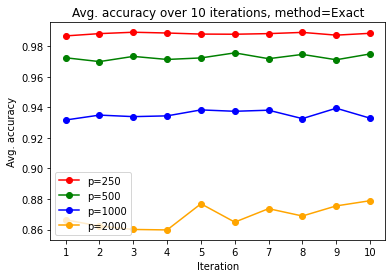

In [11]:
runSpectral()

In [13]:
#JL

def runSpectral_JL(JL=True, eps=0.1, algo='brute', method='JL + Exact'):
    runs = 10
    m = 10000
    p_set = [250, 500, 1000, 2000]
    dim_acc = defaultdict(list)
        
    for p in p_set:

        avg_sec = 0
        avg_acc = 0
        
        for it in range(runs):
            X, y = buildDataset(p)
            
            if JL:
                d = math.floor(np.log(m/(eps**2)))
                n_samples = p * d

                R = np.random.normal(0, 1, n_samples).reshape((p, d))
                Z = R / np.sqrt(d)
                X = X@Z
            
            t1 = time.perf_counter()
            acc = spectralClustering(X, y, algo=algo)
            t2 = time.perf_counter()
            avg_sec += (t2 - t1)
            avg_acc += acc
            dim_acc[p].append(acc)

        avg_sec /= runs
        avg_acc /= runs

        print(f'Avg. Accuracy = {avg_acc * 100:.3f}%, Avg. time = {avg_sec:.4f} sec, p = {p}')

        
        
    runs = np.arange(10)
    colors = ['orange','red', 'green', 'blue']
    for i, p in enumerate(p_set):
        c = colors[i]
        plt.plot(runs, dim_acc[p], color=c, label=f'p={p}', marker='o')
        plt.title(f'Avg. accuracy over {len(runs)} iterations, method={method}')
        plt.xlabel('Iteration')
        plt.ylabel('Avg. accuracy')
        plt.xticks(runs, runs+1)
        plt.legend()



Avg. Accuracy = 62.750%, Avg. time = 5.7973 sec, p = 250
Avg. Accuracy = 56.033%, Avg. time = 5.7398 sec, p = 500
Avg. Accuracy = 55.328%, Avg. time = 5.8716 sec, p = 1000
Avg. Accuracy = 52.848%, Avg. time = 5.6723 sec, p = 2000


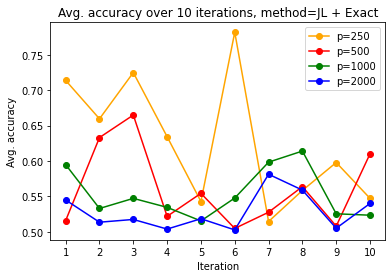

In [14]:
runSpectral_JL()

In [15]:
#JL + KD

def runSpectral_JL_KD(JL=True, eps=0.1, algo='kd_tree', method='JL + KDTree'):
    runs = 10
    m = 10000
    p_set = [250, 500, 1000, 2000]
    dim_acc = defaultdict(list)
        
    for p in p_set:

        avg_sec = 0
        avg_acc = 0
        
        for it in range(runs):
            X, y = buildDataset(p)
            
            if JL:
                d = math.floor(np.log(m/(eps**2)))
                n_samples = p * d

                R = np.random.normal(0, 1, n_samples).reshape((p, d))
                Z = R / np.sqrt(d)
                X = X@Z
            
            t1 = time.perf_counter()
            acc = spectralClustering(X, y, algo=algo)
            t2 = time.perf_counter()
            avg_sec += (t2 - t1)
            avg_acc += acc
            dim_acc[p].append(acc)

        avg_sec /= runs
        avg_acc /= runs

        print(f'Avg. Accuracy = {avg_acc * 100:.3f}%, Avg. time = {avg_sec:.4f} sec, p = {p}')

        
        
    runs = np.arange(10)
    colors = ['orange','red', 'green', 'blue']
    for i, p in enumerate(p_set):
        c = colors[i]
        plt.plot(runs, dim_acc[p], color=c, label=f'p={p}', marker='o')
        plt.title(f'Avg. accuracy over {len(runs)} iterations, method={method}')
        plt.xlabel('Iteration')
        plt.ylabel('Avg. accuracy')
        plt.xticks(runs, runs+1)
        plt.legend()


Avg. Accuracy = 63.677%, Avg. time = 5.3809 sec, p = 250
Avg. Accuracy = 55.493%, Avg. time = 5.1363 sec, p = 500
Avg. Accuracy = 55.271%, Avg. time = 4.8418 sec, p = 1000
Avg. Accuracy = 51.994%, Avg. time = 5.8370 sec, p = 2000


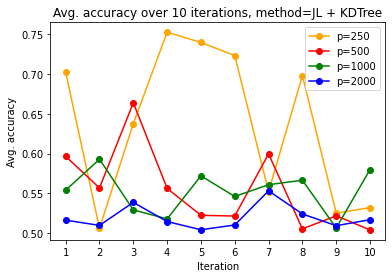

In [16]:
runSpectral_JL_KD()